In [3]:
import numpy as np

import numba as nb

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 3.0 Cython

In [4]:
%load_ext Cython

In [5]:
def primes(kmax):
    """Calculation of prime numbers in standard Python syntax"""

    p = list(range(1000))
    result = []
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result

In [6]:
@nb.autojit
def primesjit(kmax):
    """Calculation of prime numbers in standard Python syntax"""

    p = list(range(1000))
    result = []
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result

In [7]:
%%cython 

def primescy(int kmax):
    """Calculation of prime numbers with additional
    Cython keywords"""

    cdef int n, k, i
    cdef int p[1000]
    result = []
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result



In [8]:
plain = %timeit -n 5 -o primes(500)

14.5 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [9]:
jitted = %timeit -n 5 -o primesjit(500)

The slowest run took 107.07 times longer than the fastest. This could mean that an intermediate result is being cached.
9.91 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [10]:
cy = %timeit -n 5 -o primescy(500)

567 µs ± 45.1 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [11]:
plain.best/jitted.best

22.59733996360833

In [12]:
plain.best / cy.best

25.62091440368937

In [13]:
### Cython also annotates/profiles code with -a flag

<img src="cython_annotation.png" alt="cython" style="width: 300px;"/>

## ok lets try now to see how it behaves when kmax is getting larger

In [14]:
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
import matplotlib.pyplot as plt

#code to measure for kmax 1 to 500

#df = pd.DataFrame(columns=['num','plain','jit','cython'])
#for i in range(1,500):
#    pl = %timeit -n 5 -o primes(i)
#    jt = %timeit -n 5 -o primesjit(i)
#    cy = %timeit -n 5 -o primescy(i)
#    df = df.append({'num': i,'plain':pl.best,'jit':jt.best,'cython':cy.best}, ignore_index=True)
    
#however instead of running it loading a previously saved one 

df = pd.read_csv('primesresults.csv')



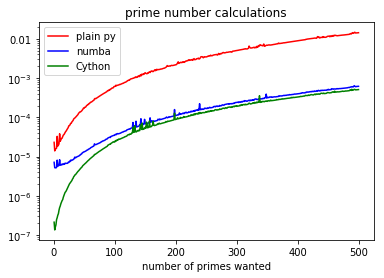

In [15]:
%matplotlib inline

plt.plot( df.num,df.plain, 'r',label='plain py')
plt.plot (df.num,df.jit, 'b',label='numba')
plt.plot(df.num,df.cython, 'g',label='Cython')

plt.title('prime number calculations')
plt.legend()
plt.xlabel('number of primes wanted')
#plt.ylabel('time(log) in sec')

plt.yscale('logit')

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.show()

In [16]:
### Another example with MC sim calculations (not ready yet)

In [17]:
#===== The problem =====

#A dice is thrown m times.
#What is the probability of getting six  *at least* n times?
#For example, if m=5 and n=3, this is the same as asking for
#the probability that three or more out of five dice show six.
#The probability can be estimated by Monte Carlo simulation.

#We simulate the process a large number of times, N, and count how
#many times, M, the experiment turned out successfully, i.e., when we
#got at least n out of m dice with six in a throw.

In [18]:
import random
def dice6_py(N, ndice, nsix):
    M = 0                     # no of successful events
    for i in range(N):        # repeat N experiments
        six = 0               # how many dice with six eyes?
        for j in range(ndice):
            r = random.randint(1, 6)  # roll die no. j
            if r == 6:
               six += 1
        if six >= nsix:       # successful event?
            M += 1
    p = float(M)/N
    return p

In [19]:
@nb.autojit
def dice6_jit(N, ndice, nsix):
    M = 0                     # no of successful events
    for i in range(N):        # repeat N experiments
        six = 0               # how many dice with six eyes?
        for j in range(ndice):
            r = random.randint(1, 6)  # roll die no. j
            if r == 6:
               six += 1
        if six >= nsix:       # successful event?
            M += 1
    p = float(M)/N
    return p

In [20]:

def dice6_vec1(N, ndice, nsix):
    eyes = np.random.random_integers(1, 6, size=(N, ndice))
    compare = eyes == 6
    throws_with_6 = np.sum(compare, axis=1)  # sum over columns
    nsuccesses = throws_with_6 >= nsix
    M = np.sum(nsuccesses)
    p = float(M)/N
    return p

In [21]:
N=1000
ndice = 6
nsix =3

In [26]:
dpy = %timeit -o -n 10 dice6_py(N,ndice,nsix)
djy = %timeit -o -n 10 dice6_jit(N,ndice,nsix)
dvy = %timeit -o -n 10 dice6_vec1(N,ndice,nsix)


7.65 ms ± 403 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.2 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
116 µs ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:


#ddf = pd.DataFrame(columns=['num','plain','jit','numpy'])
#for i in range(100,5000,50):
#    dpy = %timeit -o -n 1 dice6_py(i,ndice,nsix)
#    djy = %timeit -o -n 1 dice6_jit(i,ndice,nsix)
#    dvy = %timeit -o -n 1 dice6_vec1(i,ndice,nsix)
#    ddf = ddf.append({'num': i,'plain':dpy.best,'jit':djy.best,'numpy':dvy.best}, ignore_index=True)
    
#ddf.to_csv('diceresults.csv')
ddf=pd.read_csv('diceresults.csv')

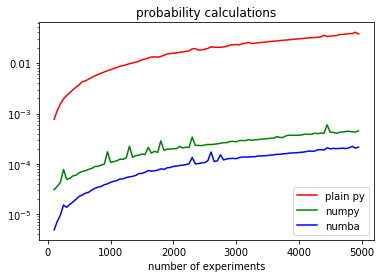

In [24]:
%matplotlib inline
plt.gca().clear()
plt.plot( ddf.num,ddf.plain, 'r',label='plain py')
plt.plot(ddf.num,ddf.numpy, 'g',label='numpy')
plt.plot (ddf.num,ddf.jit, 'b',label='numba')


plt.title('probability calculations')
plt.legend()
plt.xlabel('number of experiments')
#plt.ylabel('time(log) in sec')

plt.yscale('logit')

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.show()